### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from neuropy import plotting
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from neuropy.utils.signal_process import hilbertfast, filter_sig
from scipy.signal import find_peaks
import subjects

sess = subjects.sd.ratUday1[0]
smooth = lambda x: gaussian_filter1d(
    x, sigma=0.0125 / (1 / 1250), axis=-1
)  # 12.5 ms smoothing

### Using neuropy

In [ ]:
from neuropy.analyses.oscillations import detect_ripple_epochs

channels = sess.ripple.metadata["channels"]
signal = sess.eegfile.get_signal(channels)
ripples = detect_ripple_epochs(
    signal,
    # probegroup=sess.probegroup,
    freq_band=(125, 250),
    thresh=(2.5, None),
    edge_cutoff=0.5,
    ignore_epochs=sess.artifact,
)

# ripples.save(sess.filePrefix.with_suffix('.ripple.npy'))
# ripples.save(sess.filePrefix.with_suffix(".ripple.no_merge.npy"))

### Filter--> hilbert amp --> zscore --> smooth --> max across channels

In [11]:
def peak_epochs(power):
    power_thresh = np.where(power > 0.5, power, 0)
    peaks, properties = find_peaks(
        power_thresh, height=[2.5, None], threshold=0, prominence=0
    )
    peaks_power = power[peaks]
    starts = properties["left_bases"]
    stops = properties["right_bases"]

    n_epochs = len(starts)
    ind_delete = []
    for i in range(n_epochs - 1):
        # if two sequentially adjacent epochs with the same label
        # overlap or have less than 1 microsecond separation, merge them
        if starts[i + 1] - stops[i] < 1e-6:
            # stretch the second epoch to cover the range of both epochs
            starts[i + 1] = min(starts[i], starts[i + 1])
            stops[i + 1] = max(stops[i], stops[i + 1])
            peaks[i + 1] = [peaks[i], peaks[i + 1]][
                np.argmax([peaks_power[i], peaks_power[i + 1]])
            ]

            ind_delete.append(i)

    starts = np.delete(starts, ind_delete)
    stops = np.delete(stops, ind_delete)

    return starts, stops

In [2]:
post = sess.paradigm["post"].flatten()
period = [post[0] + 4 * 3600, post[0] + 5 * 3600]
channels = sess.ripple.metadata["channels"]
signal = sess.eegfile.get_signal(channels, t_start=period[0], t_stop=period[1])
traces_bp = filter_sig.bandpass(signal, lf=125, hf=250).traces
time = signal.time - signal.t_start

hilbert_amp = stats.zscore(np.abs(hilbertfast(traces_bp, ax=-1)), axis=-1)
hilbert_smth = smooth(hilbert_amp)
max_power = hilbert_smth.max(axis=0)
mean_power = hilbert_smth.mean(axis=0)
median_power = np.median(hilbert_smth, axis=0)

hilbert_amp = np.abs(hilbertfast(traces_bp, ax=-1))
mean_power2 = stats.zscore(smooth(hilbert_amp.mean(axis=0)))

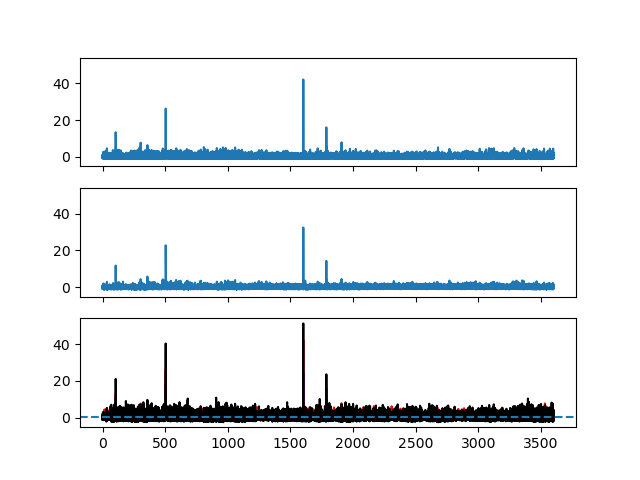

In [4]:
_, axs = plt.subplots(3, 1, sharex=True, sharey=True)

for i in range(2):
    axs[i].plot(time, hilbert_smth[i])

axs[2].plot(time, max_power, "r")
axs[2].plot(time, mean_power, "g")
axs[2].plot(time, median_power, "m")
axs[2].plot(time, mean_power2, "k")
# axs[2].plot(time[peaks],power[peaks],'*')
# axs[2].plot(time[starts],power[starts]+jitter1,'k*')
# axs[2].plot(time[stops],power[stops]+ jitter2,'r*')

# axs[2].plot(time[start_overlap],max_trace[start_overlap],'k*')
# axs[2].plot(time[stop_overlap],max_trace[stop_overlap],'r*')

axs[2].axhline(0.5, ls="--")
# axs[3].plot(time,traces_chewing[0],'g')

In [ ]:
a = np.where(max_trace > 2.5, 1, 0)
peaks, props = find_peaks(a, prominence=1, plateau_size=[2, 10])
starts, stops = props["left_bases"], props["right_bases"]
starts1, stops1 = props["left_edges"], props["right_edges"]

In [ ]:
props["plateau_sizes"], stops1 - starts1

In [ ]:
_, ax = plt.subplots(1, 1)

ax.plot(a)
ax.plot(peaks, a[peaks], ".")
ax.plot(starts, a[starts], "k.")
ax.plot(stops, a[stops], "r.")
ax.plot(starts1, a[starts1], "y.")
ax.plot(stops1, a[stops1], "g.")

ax.set_ylim([-1, 4])

### Filter--> hilbert amp --> mean --> smooth --> zscore

In [8]:
post = sess.paradigm["post"].flatten()
period = [post[0] + 5 * 3600, post[0] + 6 * 3600]
channels = sess.ripple.metadata["channels"]
signal = sess.eegfile.get_signal(channels, t_start=period[0], t_stop=period[1])
traces_bp = filter_sig.bandpass(signal, lf=125, hf=250).traces


power_thresh = np.where(power > 0.5, power, 0)
peaks, properties = find_peaks(
    power_thresh, height=[2.5, None], threshold=0, prominence=0
)
starts = properties["left_bases"]
stops = properties["right_bases"]
time = signal.time - signal.t_start

n_epochs = len(starts)
ind_delete = []
for i in range(n_epochs - 1):
    # if two sequentially adjacent epochs with the same label
    # overlap or have less than 1 microsecond separation, merge them
    if starts[i + 1] - stops[i] < 1e-6:
        # stretch the second epoch to cover the range of both epochs
        starts[i + 1] = min(starts[i], starts[i + 1])
        stops[i + 1] = max(stops[i], stops[i + 1])

        ind_delete.append(i)

starts = np.delete(starts, ind_delete)
stops = np.delete(stops, ind_delete)


start_overlap = starts[np.where(np.diff(starts) == 0)[0]]
stop_overlap = stops[np.where(np.diff(stops) == 0)[0]]
print(len(starts), len(stops))
print(len(start_overlap), len(stop_overlap))

1863 1863
0 0


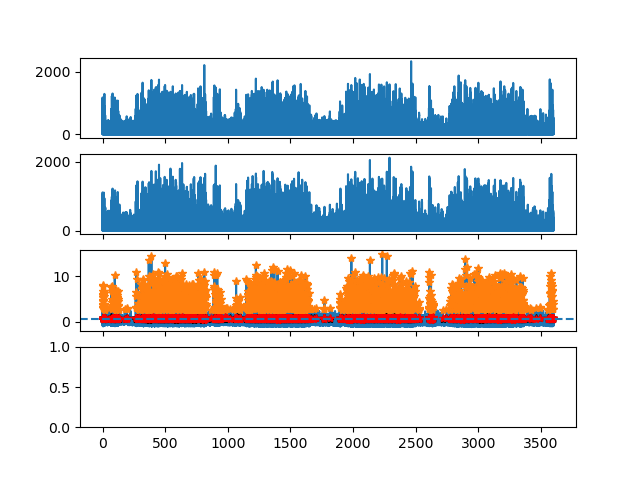

In [10]:
_, axs = plt.subplots(4, 1, sharex=True, sharey=False)
jitter1 = np.random.random(len(starts)) * 0.4
jitter2 = np.random.random(len(stops)) * 0.4

for i in range(2):
    axs[i].plot(time, hilbert_amp[i])

axs[2].plot(time, power)
axs[2].plot(time[peaks], power[peaks], "*")
axs[2].plot(time[starts], power[starts] + jitter1, "k*")
axs[2].plot(time[stops], power[stops] + jitter2, "r*")

# axs[2].plot(time[start_overlap],max_trace[start_overlap],'k*')
# axs[2].plot(time[stop_overlap],max_trace[stop_overlap],'r*')

axs[2].axhline(0.5, ls="--")
# axs[3].plot(time,traces_chewing[0],'g')